In [1]:
import numpy as np
import pandas as pd
import yfinance as yf

# Momentum Trading Strategy

## Download Data

In [2]:
import os

cwd = os.getcwd()
# Check if price data have been saved
price_data = os.path.join(cwd, "price_data")
if not os.path.exists(price_data):
    # Getting the Nasdaq 100 ticker symbols from Wikipedia
    nas_df = pd.read_html("https://en.wikipedia.org/wiki/Nasdaq-100")[4]
    tickers = nas_df.Ticker.to_list()
    # Download the Nasdaq 100 Adjusted Close price data with yfinance
    df = yf.download(tickers, start="2010-01-01")
    # Create price_data directory
    os.makedirs(price_data)
    # Save a copy of the dataframe to price_data directory
    df.to_csv(os.path.join(price_data, "Nasdaq-100.csv"))
else:
    # Load the Nasdaq-100.csv
    df = pd.read_csv(os.path.join(price_data, "Nasdaq-100.csv"), 
                     header=[0,1], index_col=0)
    df.index = pd.to_datetime(df.index)

## Functions for Calculate Cumulative Returns

In [50]:
def get_top(df, periods, top_picks):
    # Check if periods and top_picks has the same length
    assert len(periods) == len(top_picks), \
        "Length of periods and length of top_picks is not the same"
    # Initializing all availible symbols from dataframe columns
    symbols = df.columns.to_list()
    # Looping through both periods and top_picks to pick out
    # the top performance tickers
    for p, t in zip(periods, top_picks):
        # Calculate the cumulative product of the given period
        # also droping any columns containing NaN value
        ret = df[symbols].dropna(axis=1).iloc[-p:].prod()
        # Picking the top N ticker symbols for the next round
        symbols = ret.nlargest(t).index.to_list()
    # return the top performance tickers symbols
    return symbols

In [69]:
def cal_returns(
    df,
    periods=[12, 6, 3],
    top_picks=[50, 30, 10]):

    max_p = max(periods) + 1
    returns = []
    picks = []

    for i in range(max_p, len(df)):
        s, e = i - max_p, i - 1
        # Getting top 10 ticker symbol
        topk_tickers = get_top(df.iloc[s:e], periods, top_picks)
        # Getting the portfolio performance
        pf = np.mean(df[topk_tickers].iloc[i])
        # Appending datas
        returns.append(pf)
        picks += topk_tickers
    
    return dict(
        picks=pd.Series(picks).value_counts(),
        returns=pd.Series(returns, index=df.index[max_p:]))

In [83]:
def plot_results(results):
    # Plotting the Return curve
    picks_df = results['picks']
    ret_df = results['returns']
    print(f"Current cumulative return: {ret_df.prod():.2f}")
    ret_df.cumprod().plot()

## Base


In [8]:
m_first = df["Adj Close"].groupby(by=pd.Grouper(freq="M")).first()
m_last = df["Adj Close"].groupby(by=pd.Grouper(freq="M")).last()
# Calculate the percent change by dividing the adjusted closed price of 
# last day of the month by the first day of the month
m_pct = m_last / m_first

In [72]:
results = cal_returns(m_pct)

Current cumulative return: 21.40


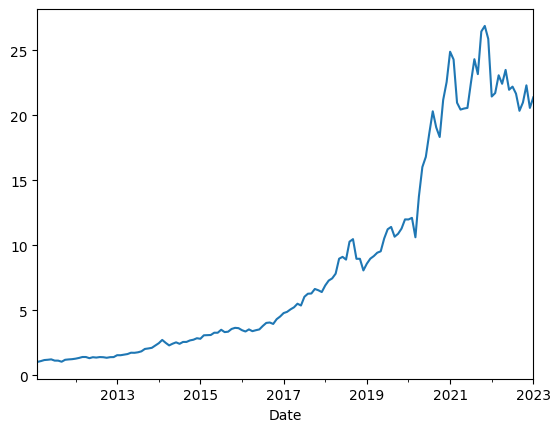

In [84]:
plot_results(results)

Adj Close                                                 \
                  AAPL       ABNB        ADBE         ADI         ADP   
Date                                                                    
2010-01-04    6.515213        NaN   37.090000   23.067623   27.491219   
2010-01-05    6.526476        NaN   37.700001   23.031210   27.343588   
2010-01-06    6.422665        NaN   37.619999   22.987505   27.279404   
2010-01-07    6.410790        NaN   36.889999   22.805407   27.266567   
2010-01-08    6.453412        NaN   36.689999   22.936510   27.228037   
...                ...        ...         ...         ...         ...   
2023-01-04  126.360001  88.720001  341.410004  165.910004  238.779999   
2023-01-05  125.019997  87.709999  328.440002  159.690002  233.630005   
2023-01-06  129.619995  88.519997  332.750000  165.520004  240.160004   
2023-01-09  130.149994  89.239998  341.980011  167.100006  239.509995   
2023-01-10  130.729996  88.540001  338.700012  169.220001  240.779999   

                                                                      ...  \
                  ADSK        AEP        ALGN        AMAT        AMD  ...   
Date                                                                  ...   
2010-01-04   25.670000  21.142141   18.500000   11.328531   9.700000  ...   
2010-01-05   25.280001  20.900097   18.010000   11.241387   9.710000  ...   
2010-01-06   25.340000  21.111883   17.480000   11.217620   9.570000  ...   
2010-01-07   25.480000  21.293417   17.430000   11.098792   9.470000  ...   
2010-01-08   26.260000  21.547558   17.660000   11.526580   9.430000  ...   
...                ...        ...         ...         ...        ...  ...   
2023-01-04  187.960007  95.519997  224.630005   99.309998  64.660004  ...   
2023-01-05  182.070007  93.779999  219.820007   97.919998  62.330002  ...   
2023-01-06  187.190002  96.529999  220.770004  104.269997  63.959999  ...   
2023-01-09  192.470001  97.949997  227.669998  106.489998  67.239998  ...   
2023-01-10  193.429993  97.279999  232.250000  108.040001  68.050003  ...   

                 Volume                                                  \
                   TSLA       TXN     VRSK     VRTX       WBA       WBD   
Date                                                                      
2010-01-04          NaN  10369300   390000  1744900   8171000   2844108   
2010-01-05          NaN  10943800   430000  2456500  10843200   3193041   
2010-01-06          NaN   8933800   848900  2313700   8945400   3873099   
2010-01-07          NaN  10775400   426600  1873200   5040700   2506526   
2010-01-08          NaN  12875600   253200  3687900   6139800   2448598   
...                 ...       ...      ...      ...       ...       ...   
2023-01-04  180389000.0   6285300   603200  1137400   7987000  34435900   
2023-01-05  157986300.0   6876800   693300  1187000  19328200  33761600   
2023-01-06  220575900.0   6725000   728700   943400  10009200  29833400   
2023-01-09  190284000.0   5733900  1095800  1299200   9435000  25383800   
2023-01-10  167356900.0   4267700   403000  1038900   6340800  43196800   

                                                      
                 WDAY      XEL         ZM         ZS  
Date                                                  
2010-01-04        NaN  2670400        NaN        NaN  
2010-01-05        NaN  4321400        NaN        NaN  
2010-01-06        NaN  2164500        NaN        NaN  
2010-01-07        NaN  3041700        NaN        NaN  
2010-01-08        NaN  1599100        NaN        NaN  
...               ...      ...        ...        ...  
2023-01-04  1660200.0  2265900  3209600.0  1617000.0  
2023-01-05  3003800.0  2104500  2040100.0  3931100.0  
2023-01-06  1910300.0  2976200  4078300.0  2612800.0  
2023-01-09  1727600.0  2707800  3403000.0  2961300.0  
2023-01-10  1824857.0  3027500  1851248.0  2912538.0  

[3278 rows x 606 columns]